In [1]:
from keras._tf_keras.keras.models import Sequential, load_model, save_model
from keras._tf_keras.keras.regularizers import L1, L2, L1L2
from keras._tf_keras.keras.optimizers import Adam
from keras._tf_keras.keras.metrics import Accuracy, F1Score, Precision, Recall
from keras._tf_keras.keras.losses import CategoricalCrossentropy, SparseCategoricalCrossentropy
from keras._tf_keras.keras.callbacks import Callback
from keras._tf_keras.keras.utils import to_categorical
from sklearn.metrics import classification_report, roc_curve
import keras._tf_keras.keras.datasets as datasets
import keras._tf_keras.keras.layers as layers

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import cv2 as cv
from PIL import Image

In [2]:
# Adjust HyperParameters

INPUT_SHAPE = (8,)
IMAGE_SIZE = 0
EPOCHS = 30
BATCH_SIZE = 32
NUM_CLASSES = 0
LABELS = {}

In [3]:
def display_shapes(x_train, y_train, x_test, y_test) -> None:
    print(f"X-Train : {x_train.shape}")
    print(f"Y-Train : {y_train.shape}")
    print(f"X-Test  : {x_test.shape}")
    print(f"Y-Test  : {y_test.shape}")

def display_classes(x : np.ndarray, y : np.ndarray, num_classes : int) -> None:
    plt.figure(figsize=(12, 6))
    for i in range(num_classes):
        class_indices = np.where(y.flatten() == i)[0]
        random_index = np.random.choice(class_indices)
        image = x[random_index]

        plt.subplot(2, 5, i + 1)
        plt.imshow(image)
        try : plt.title(LABELS[i])
        except : plt.title(f"Class No. : {i}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

def display_results(x : np.ndarray, y : np.ndarray, pred : np.ndarray) -> None:
    plt.figure(figsize=(15, 6))
    for i in range(NUM_CLASSES):
        class_indices = np.where(y.flatten() == i)[0]
        random_index = np.random.choice(class_indices)
        image = x[random_index]

        plt.subplot(2, 5, i + 1)
        plt.imshow(image)
        plt.title(f'Target: {LABELS[i]}, Pred: {LABELS[np.argmax(pred[random_index])]}')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

In [4]:
# Initializing The Dataset :

(x_train, y_train) , (x_test, y_test) = datasets.california_housing.load_data()

df_train = pd.DataFrame(x_train)
df_train.columns = ['longitude','latitude','housing_median_age','total_rooms','total_bedrooms','population','households','median_income']
df_train['median_house_value'] = y_train
display(df_train)

display_shapes(x_train, y_train, x_test, y_test)


longitude   latitude  housing_median_age  total_rooms  total_bedrooms  \
0     -118.269997  34.090000                52.0       2327.0           555.0   
1     -118.360001  33.959999                21.0       1802.0           556.0   
2     -122.389999  37.759998                52.0       1877.0           427.0   
3     -117.949997  33.919998                11.0       3127.0           706.0   
4     -122.519997  37.919998                24.0        421.0            64.0   
...           ...        ...                 ...          ...             ...   
16507 -122.029999  37.349998                19.0       3811.0          1227.0   
16508 -118.440002  34.189999                19.0       3487.0           959.0   
16509 -122.339996  37.570000                52.0       2547.0           373.0   
16510 -122.180000  37.889999                18.0       4845.0           735.0   
16511 -118.430000  34.200001                29.0       3051.0           694.0   

       population  households  median_income  median_house_value  
0          1048.0       491.0         3.7847            252300.0  
1          1286.0       557.0         2.7284            146900.0  
2           712.0       398.0         3.9722            290900.0  
3          1594.0       694.0         4.3426            141300.0  
4           163.0        75.0        14.5833            500001.0  
...           ...         ...            ...                 ...  
16507      1930.0      1153.0         3.5154            311400.0  
16508      2278.0       835.0         2.6709            215500.0  
16509       876.0       359.0         8.2598            500001.0  
16510      1634.0       734.0         8.1489            499000.0  
16511      1942.0       679.0         3.1118            238100.0  

[16512 rows x 9 columns]

X-Train : (16512, 8)
Y-Train : (16512,)
X-Test  : (4128, 8)
Y-Test  : (4128,)


array([[<Axes: xlabel='longitude', ylabel='longitude'>,
        <Axes: xlabel='latitude', ylabel='longitude'>,
        <Axes: xlabel='housing_median_age', ylabel='longitude'>,
        <Axes: xlabel='total_rooms', ylabel='longitude'>,
        <Axes: xlabel='total_bedrooms', ylabel='longitude'>,
        <Axes: xlabel='population', ylabel='longitude'>,
        <Axes: xlabel='households', ylabel='longitude'>,
        <Axes: xlabel='median_income', ylabel='longitude'>,
        <Axes: xlabel='median_house_value', ylabel='longitude'>],
       [<Axes: xlabel='longitude', ylabel='latitude'>,
        <Axes: xlabel='latitude', ylabel='latitude'>,
        <Axes: xlabel='housing_median_age', ylabel='latitude'>,
        <Axes: xlabel='total_rooms', ylabel='latitude'>,
        <Axes: xlabel='total_bedrooms', ylabel='latitude'>,
        <Axes: xlabel='population', ylabel='latitude'>,
        <Axes: xlabel='households', ylabel='latitude'>,
        <Axes: xlabel='median_income', ylabel='latitude'>,
    

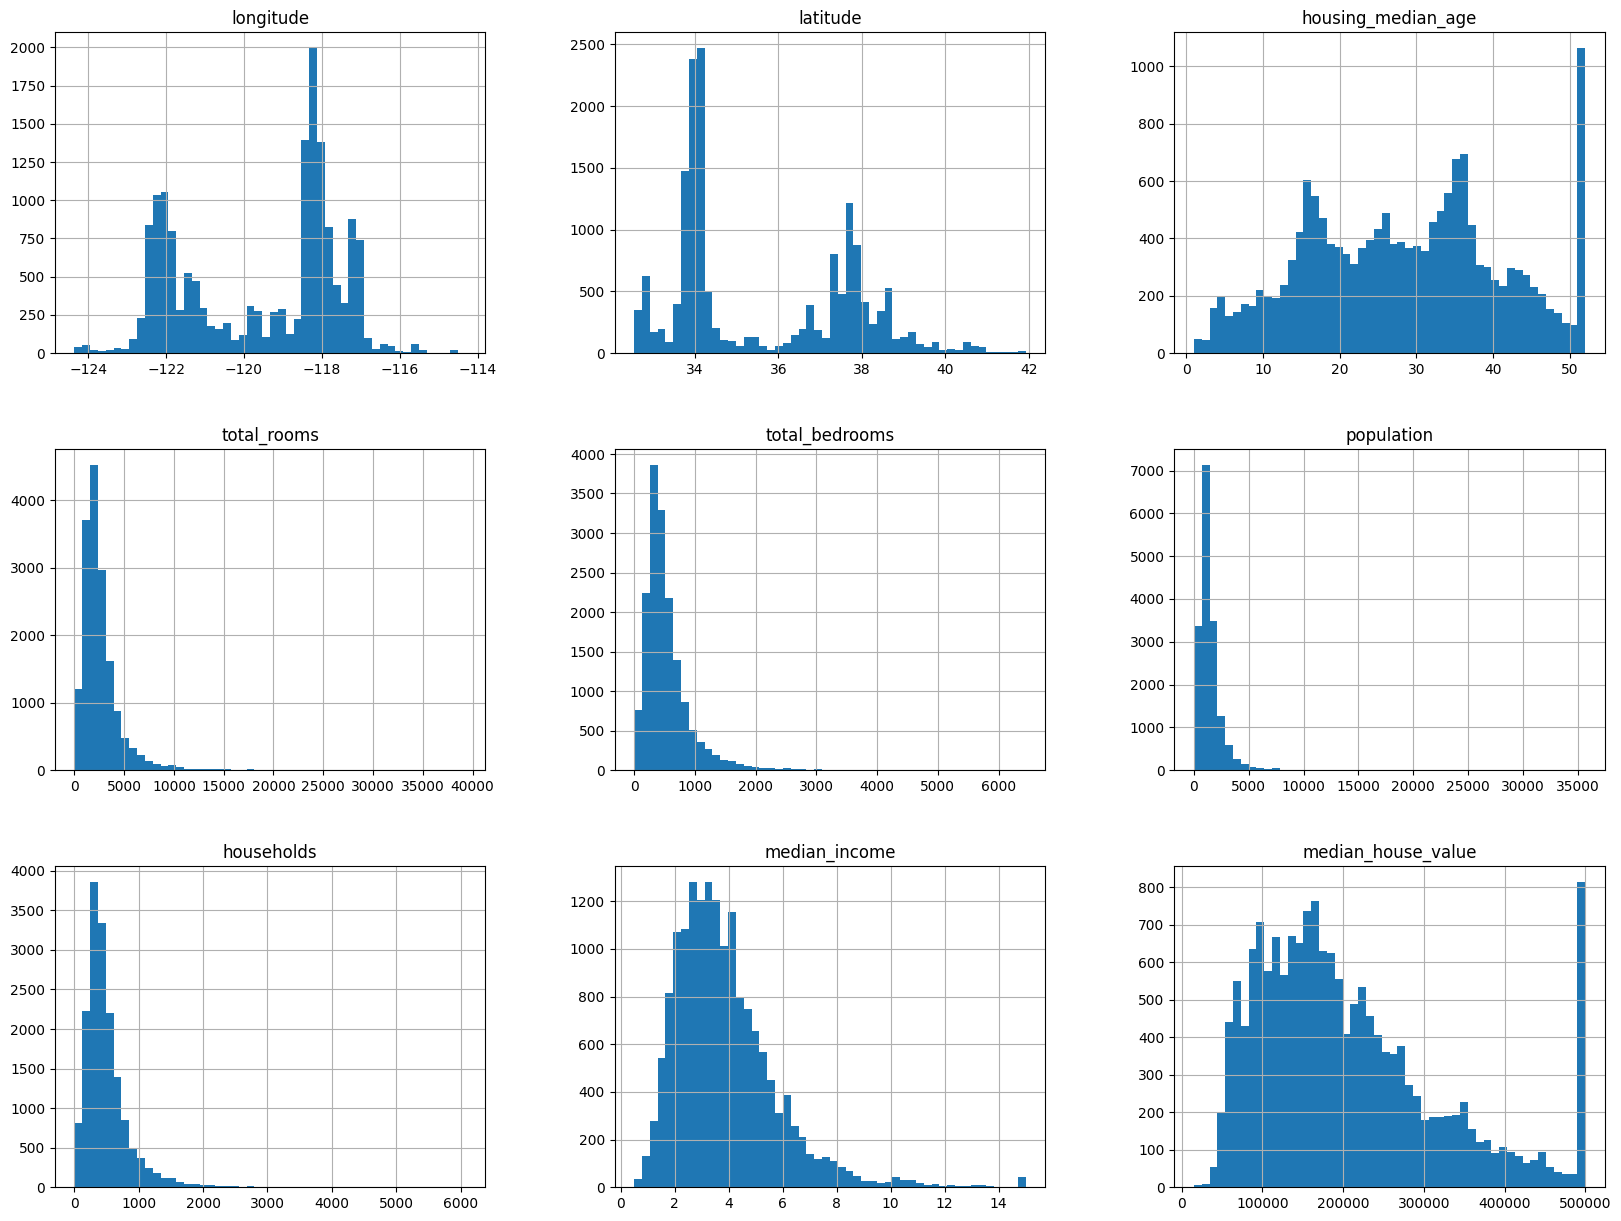

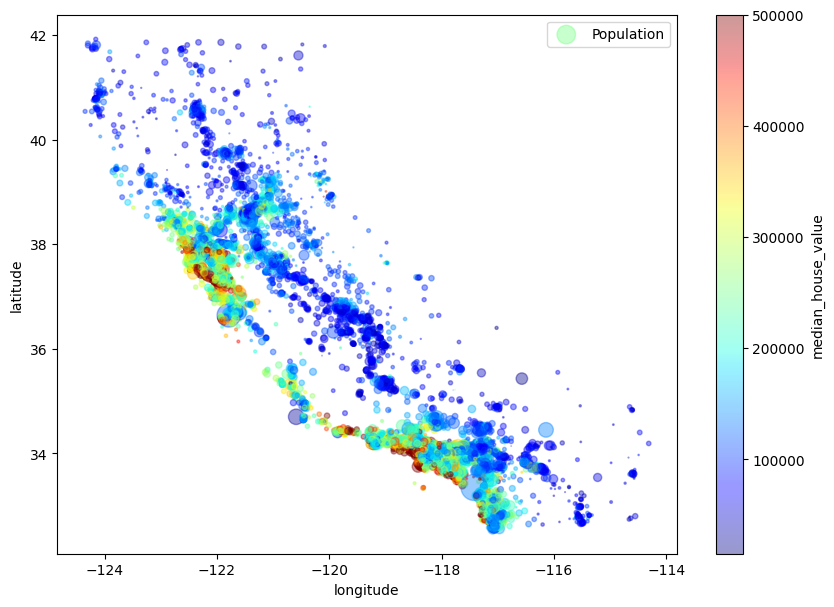

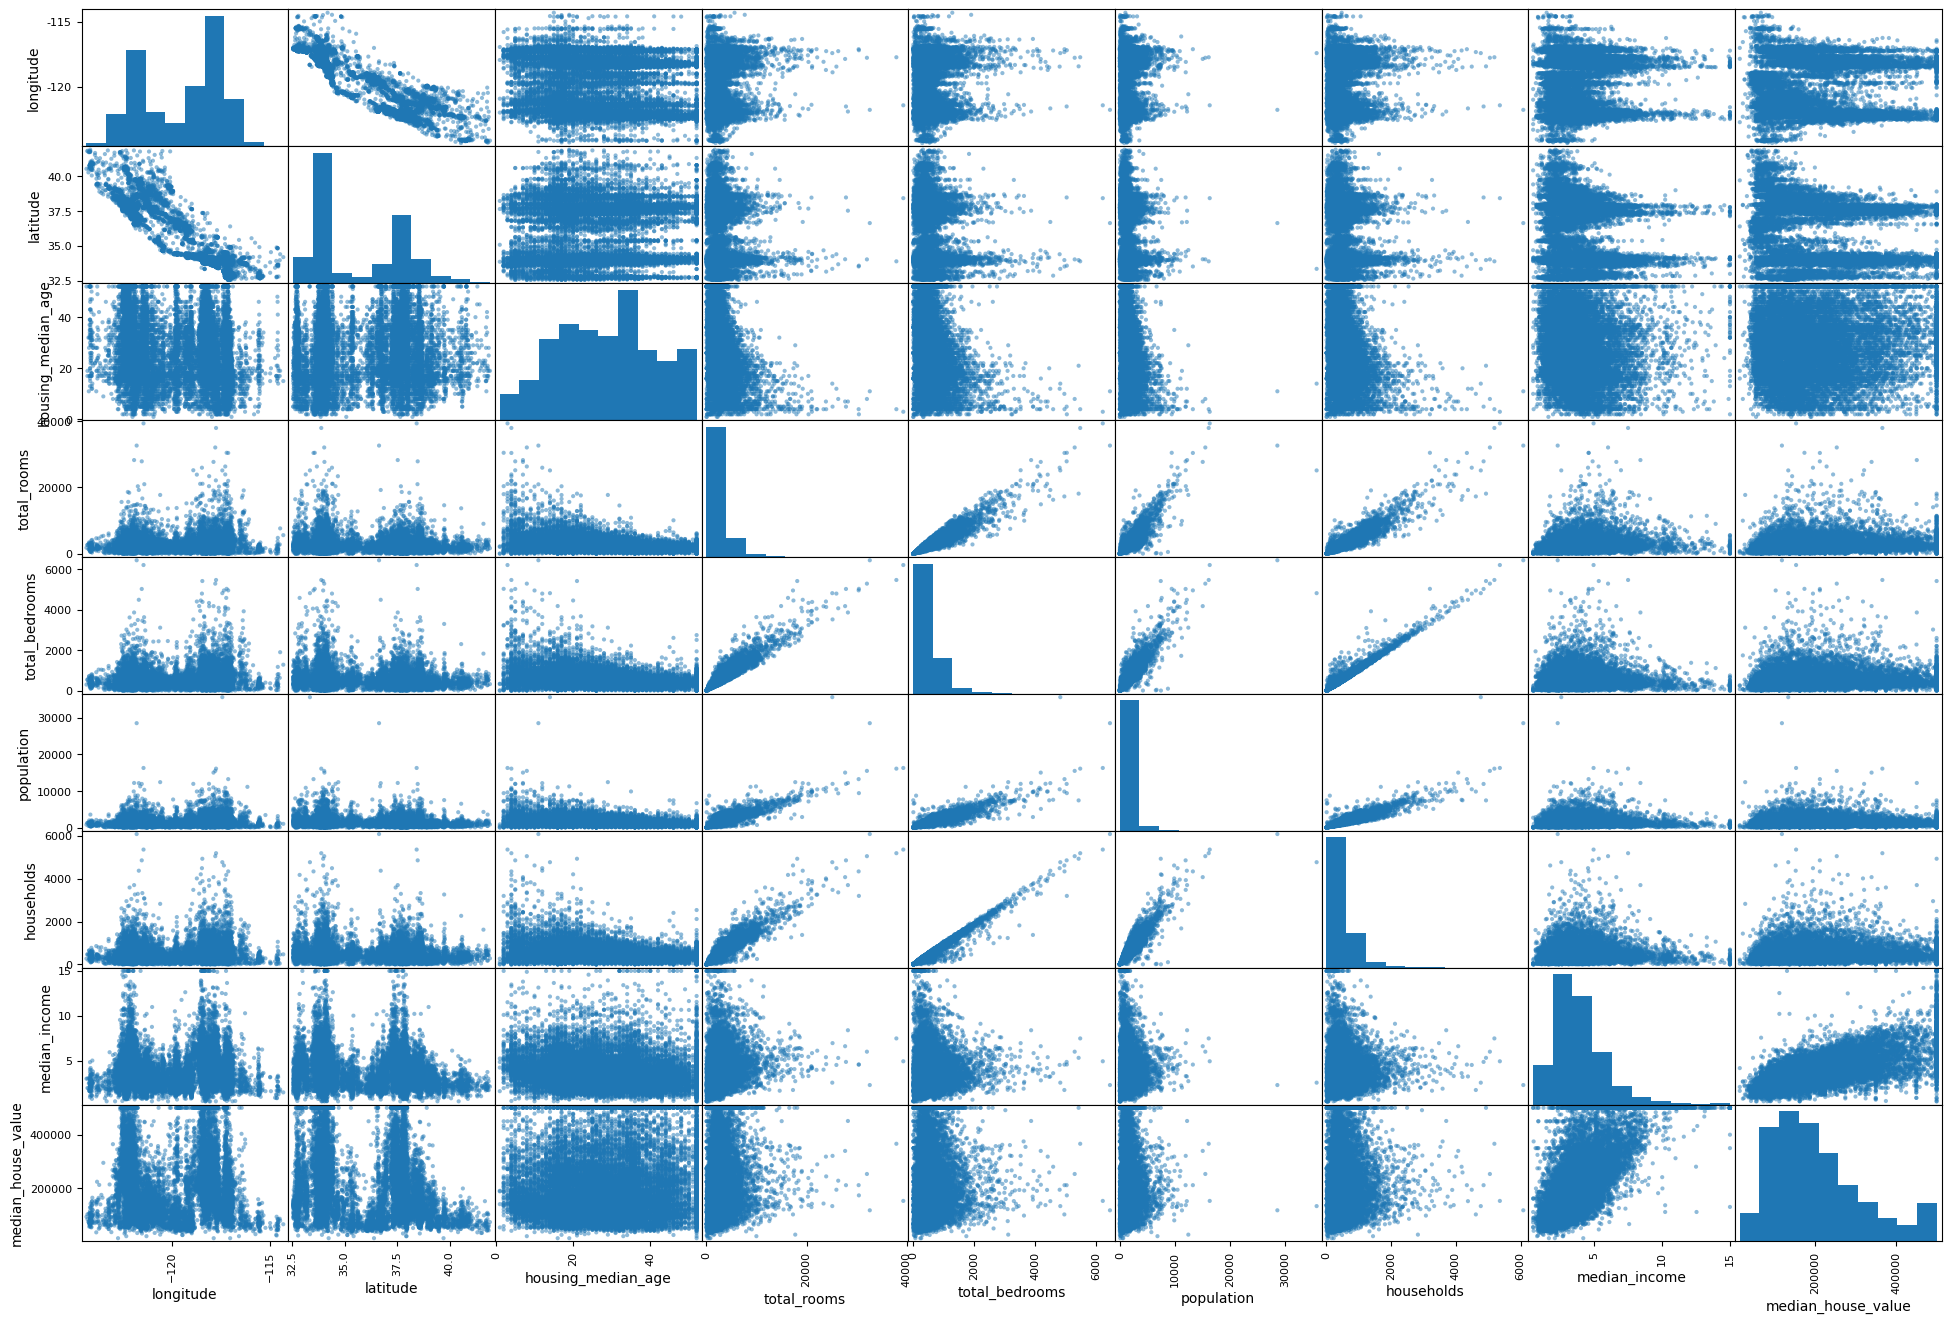

In [30]:
# Analyzing Data Distribution :

from pandas.plotting import scatter_matrix

df_train.hist(bins=50, figsize=(20, 15))

df_train.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
             s=df_train["population"]/100, label="Population", figsize=(10, 7),
             c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True, 
             sharex=False)

plt.legend()

attributes = df_train.columns
scatter_matrix(df_train[attributes], figsize=(24, 16))

In [6]:
# Main Model Structure :

model = Sequential(name='Regression-Model')

model.add(layers.Input(shape=INPUT_SHAPE))

model.add(layers.BatchNormalization())
model.add(layers.Dense(units=64, activation='relu'))
model.add(layers.Dense(units=128, activation='relu'))
model.add(layers.Dense(units=256, activation='relu'))
model.add(layers.Dense(units=512, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dense(units=512, activation='relu'))
model.add(layers.Dense(units=256, activation='relu'))
model.add(layers.Dense(units=128, activation='relu'))
model.add(layers.Dense(units=32, activation='relu'))
model.add(layers.Dense(units=1, activation='linear'))

model.summary()


Model: "Regression-Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization             │ (None, 8)              │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 606,625 (2.31 MB)

 Trainable params: 605,585 (2.31 MB)

 Non-trainable params: 1,040 (4.06 KB)

In [7]:
# Model Compile :

model.compile(optimizer='adam', loss='mse', metrics=['mae'])

In [8]:
# Fitting The Model :

model.fit(x=x_train,
          y=y_train,
          batch_size=BATCH_SIZE,
          epochs=EPOCHS,
          validation_data=[x_test, y_test])

Epoch 1/30
516/516 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 23328706560.0000 - mae: 108533.3828 - val_loss: 4786563584.0000 - val_mae: 50390.1211
Epoch 2/30
516/516 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 4713317888.0000 - mae: 49601.9336 - val_loss: 4302904832.0000 - val_mae: 44920.7891
Epoch 3/30
516/516 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 4309023744.0000 - mae: 47259.1797 - val_loss: 3653930496.0000 - val_mae: 43950.4688
Epoch 4/30
516/516 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 4328576000.0000 - mae: 47374.9727 - val_loss: 3626369024.0000 - val_mae: 41565.1484
Epoch 5/30
516/516 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 4242513152.0000 - mae: 46877.8594 - val_loss: 3658787584.0000 - val_mae: 43445.1875
Epoch 6/30
516/516 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 4179617280.0000 - mae: 46070.2344 - val_loss: 3629187584.0000 - val_mae: 40588.2227
Epoch 7/30
516/516 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 4196438016.0000 - mae: 46069.4727 - val_loss: 3369306624.0000 - val_mae: 4

In [9]:
# Evaluating The Model :

evaluation = model.evaluate(x_test, y_test)
loss = evaluation[0]
mae = evaluation[1]

print(f"Mean Sqaured Error : {loss}\nMean Absolute Error : {mae}")

129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3127720192.0000 - mae: 38109.9727
Mean Sqaured Error : 3061609728.0
Mean Absolute Error : 37855.1328125


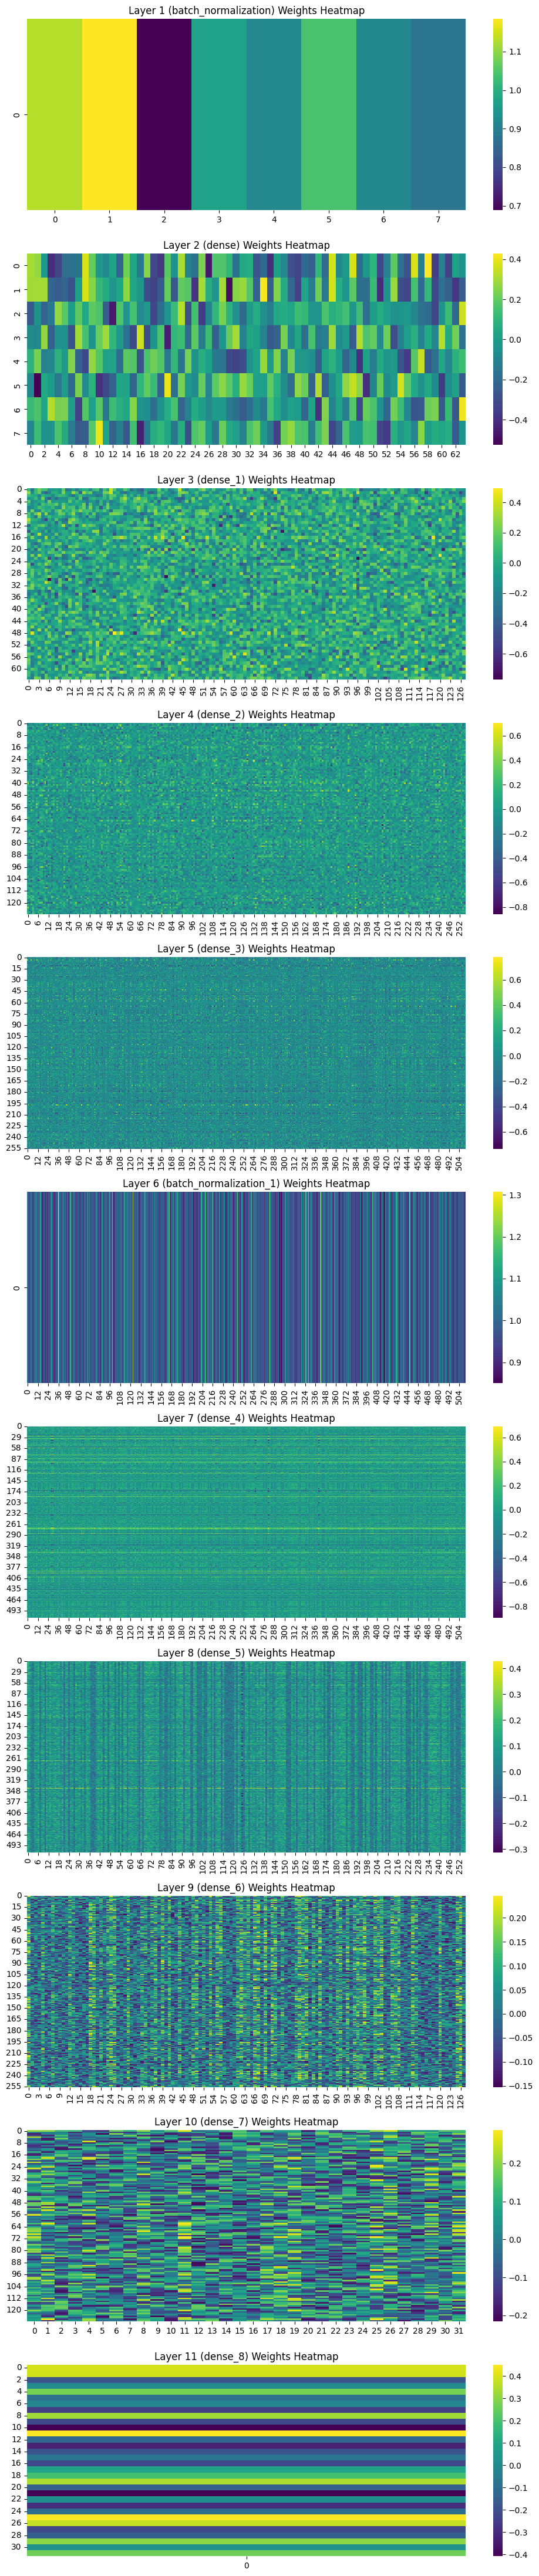

In [ ]:
num_layers = len(model.layers) 
fig, axes = plt.subplots(num_layers, 1, figsize=(10, 4 * num_layers)) 

for i, layer in enumerate(model.layers):
    if layer.get_weights():
        weights = layer.get_weights()[0]

        if weights.ndim == 1:
            weights = np.expand_dims(weights, axis=0)

        ax = axes if num_layers == 1 else axes[i]

        sns.heatmap(weights, cmap="viridis", annot=False, ax=ax)
        ax.set_title(f"Layer {i+1} ({layer.name}) Weights Heatmap")

plt.tight_layout()
plt.show()

129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


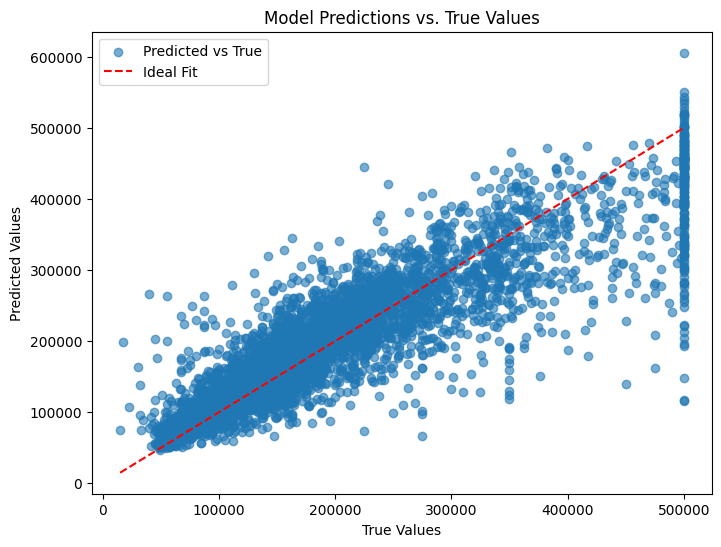

In [15]:
y_pred = model.predict(x_test)

plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.6, label="Predicted vs True")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--', label='Ideal Fit')
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("Model Predictions vs. True Values")
plt.legend()
plt.show()

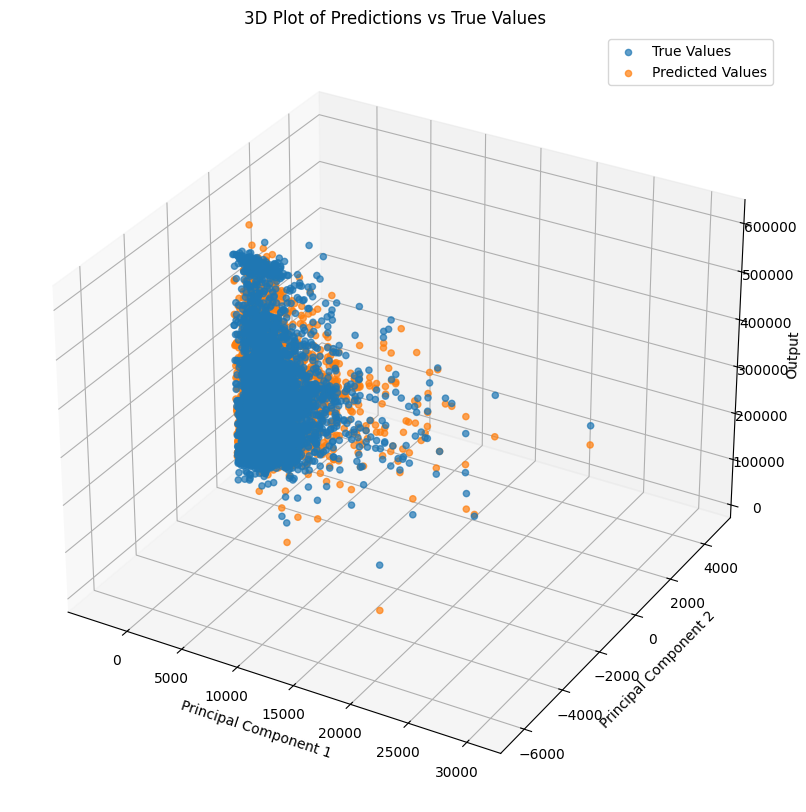

In [23]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
x_test_pca = pca.fit_transform(x_test)

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(x_test_pca[:, 0], x_test_pca[:, 1], y_test, label="True Values", alpha=0.7)
ax.scatter(x_test_pca[:, 0], x_test_pca[:, 1], y_pred, label="Predicted Values", alpha=0.7)

ax.set_xlabel("Principal Component 1")
ax.set_ylabel("Principal Component 2")
ax.set_zlabel("Output")
plt.title("3D Plot of Predictions vs True Values")
plt.legend()
plt.show()
